Please download the dataset from this <a href="https://aimedu.sharepoint.com/:u:/s/CapstoneTeam563/ETCqJZQwfa1CibDllUWaPEUBZu607_r1ZZabsiPzj71qQA?e=iy6wGU">link</a> and run the `ML3_Project_Dataset.ipynb` before running this.

# Import

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

from sklearn.metrics import accuracy_score, precision_score, recall_score
import seaborn as sns

In [2]:
from PIL import Image

# Disable the decompression bomb limit
Image.MAX_IMAGE_PIXELS = None

# MalwareInSight

In [3]:
data_dir = 'malimg'

# Set a random seed for reproducibility
SEED = 74797569

# Define paths
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')

# Create an ImageDataGenerator for each set
datagen = ImageDataGenerator(rescale=1./255)

batch_size = 64
image_dim = 256

# Create train generator
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(image_dim, image_dim),
    batch_size=batch_size,
    shuffle=True,
    #color_mode='grayscale',
    class_mode='categorical',  # or 'categorical' if you have multiple classes
    seed=SEED
)

# Create validation generator
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(image_dim, image_dim),
    batch_size=batch_size,
    shuffle=True,
    #color_mode='grayscale',
    class_mode='categorical',  # or 'categorical' if you have multiple classes
    seed=SEED
)

# Create test generator
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(image_dim, image_dim),
    batch_size=batch_size,
    shuffle=False,
    #color_mode='grayscale',
    class_mode='categorical',  # or 'categorical' if you have multiple classes
    seed=SEED
)

Found 6527 images belonging to 25 classes.
Found 1867 images belonging to 25 classes.
Found 945 images belonging to 25 classes.


In [4]:
# Shape check
for samples, targets in train_generator:
    print(f"Samples shape: {samples.shape}")
    print(f"Targets shape: {targets.shape}")
    break

Samples shape: (64, 256, 256, 3)
Targets shape: (64, 25)


In [5]:
keras.backend.clear_session()

inputs = keras.Input(shape=(image_dim, image_dim, 3))

# Initial Conv Layers
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
x = layers.MaxPool2D((3, 3))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same',)(x)
x = layers.MaxPool2D((3, 3))(x)

# Flatten and Dense Layers
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.30)(x)

outputs = layers.Dense(25, activation='softmax')(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer=Adam(),loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint('malimg_models/model_malwareinsight.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00005, verbose=1)
tensorboard = TensorBoard(log_dir='./logs/', histogram_freq=1)

callbacks = [checkpoint, early_stopping, reduce_lr, tensorboard]

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 85, 85, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 85, 85, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,625 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,900,281 (49.21 MB)

 Trainable params: 12,900,281 (49.21 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
history_malwareinsight = model.fit(
    train_generator,
    epochs=40,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/40


/opt/conda/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.4310 - loss: 2.2904

/opt/conda/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.92234, saving model to malimg_models/model_malwareinsight.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 59s 486ms/step - accuracy: 0.4331 - loss: 2.2819 - val_accuracy: 0.9223 - val_loss: 0.3135 - learning_rate: 0.0010
Epoch 2/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9013 - loss: 0.3896
Epoch 2: val_accuracy improved from 0.92234 to 0.96840, saving model to malimg_models/model_malwareinsight.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 40s 376ms/step - accuracy: 0.9014 - loss: 0.3890 - val_accuracy: 0.9684 - val_loss: 0.1193 - learning_rate: 0.0010
Epoch 3/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.9365 - loss: 0.2103
Epoch 3: val_accuracy improved from 0.96840 to 0.96947, saving model to malimg_models/model_malwareinsight.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 36s 340ms/step - accuracy: 0.9364 - loss: 0.2103 - val_accuracy: 0.9695 - val_loss: 0.1030 - learning_rate: 0.0010
Epoch 4/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step -

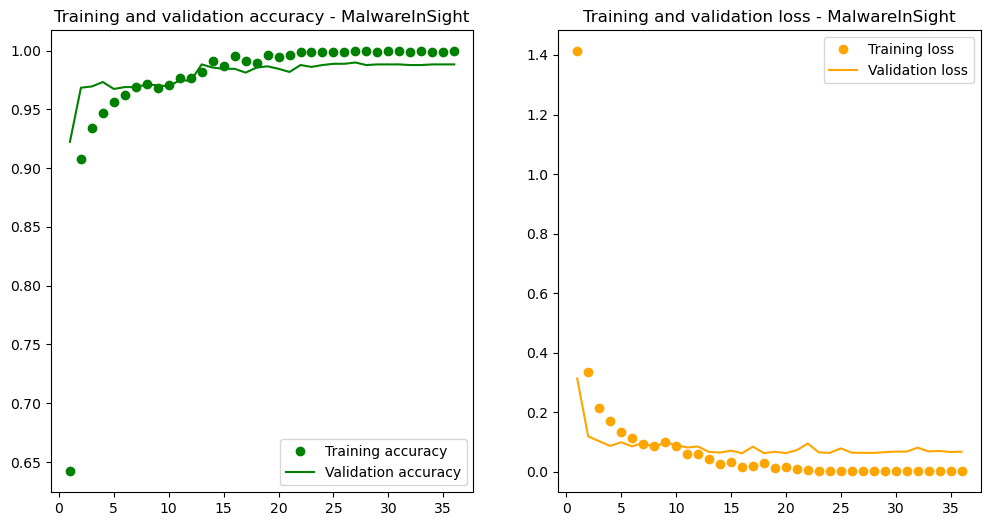

In [41]:
acc = history_malwareinsight.history['accuracy']
val_acc = history_malwareinsight.history['val_accuracy']
loss = history_malwareinsight.history['loss']
val_loss = history_malwareinsight.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

plt.plot(epochs, acc, 'go', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy - MalwareInSight')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'o', label='Training loss', color='orange')
plt.plot(epochs, val_loss, label='Validation loss', color='orange')
plt.title('Training and validation loss - MalwareInSight')
plt.legend()
plt.savefig('malwareinsight_accloss.jpg')
plt.show()

## Testing

Stochasticity was observed when trying to replicate results. Best saved model from previous iterations will be used. No changes in the architecture and settings were done.

In [29]:
data_dir = 'malimg'

# Set a random seed for reproducibility
SEED = 74797569

# Define paths
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')

# Create an ImageDataGenerator for each set
datagen = ImageDataGenerator(rescale=1./255)

batch_size = 64
image_dim = 256

# Create train generator
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(image_dim, image_dim),
    batch_size=batch_size,
    shuffle=True,
    #color_mode='grayscale',
    class_mode='categorical',  # or 'categorical' if you have multiple classes
    seed=SEED
)

# Create validation generator
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(image_dim, image_dim),
    batch_size=batch_size,
    shuffle=True,
    #color_mode='grayscale',
    class_mode='categorical',  # or 'categorical' if you have multiple classes
    seed=SEED
)

# Create test generator
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(image_dim, image_dim),
    batch_size=batch_size,
    shuffle=False,
    #color_mode='grayscale',
    class_mode='categorical',  # or 'categorical' if you have multiple classes
    seed=SEED
)

Found 6527 images belonging to 25 classes.
Found 1867 images belonging to 25 classes.
Found 945 images belonging to 25 classes.


### Latest model

In [36]:
test_model = models.load_model('malimg_models/model_malwareinsight.keras')
# Evaluate the model on the test data using `evaluate`
test_loss, test_accuracy = test_model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - accuracy: 0.9971 - loss: 0.0207
Test Loss: 0.06649427860975266
Test Accuracy: 0.9904761910438538


In [37]:
predictions = test_model.predict(test_generator)
pred_labels = predictions.argmax(axis=1)
true_labels = test_generator.classes

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 223ms/step


In [38]:
print('Accuracy: ', accuracy_score(true_labels, pred_labels))
print('Precision: ', precision_score(true_labels, pred_labels, average='macro'))
print('Recall: ', recall_score(true_labels, pred_labels, average='macro'))

Accuracy:  0.9904761904761905
Precision:  0.9790243902439024
Recall:  0.9752588224783346


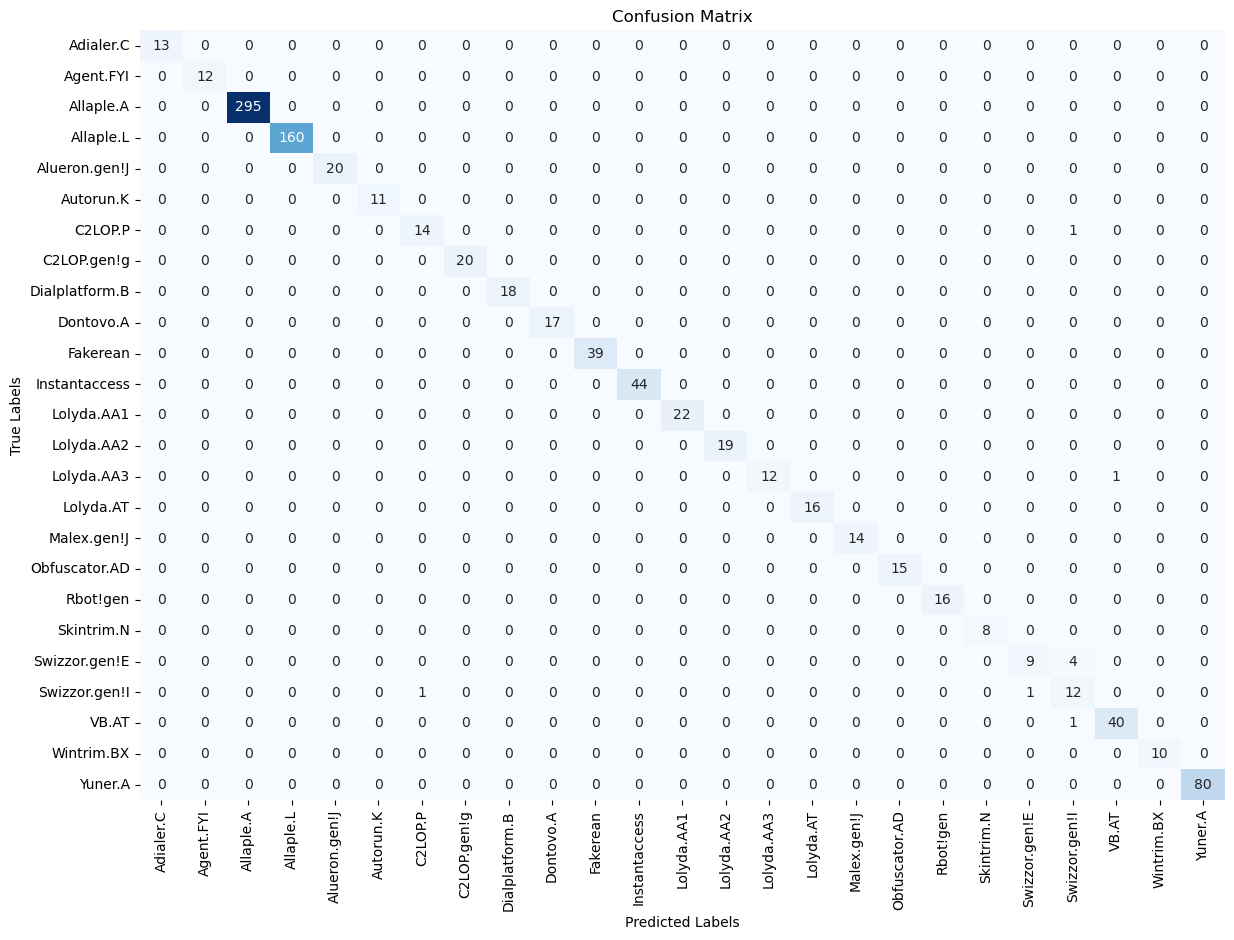

In [39]:
confusion_matrix = tf.math.confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(14, 10))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys()
           )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Previous best (model in presentation)

In [33]:
test_model = models.load_model('malimg_models/model_9894.keras')
# Evaluate the model on the test data using `evaluate`
test_loss, test_accuracy = test_model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 246ms/step - accuracy: 0.9961 - loss: 0.0153
Test Loss: 0.04328785091638565
Test Accuracy: 0.9894179701805115


In [34]:
predictions = test_model.predict(test_generator)
pred_labels = predictions.argmax(axis=1)
true_labels = test_generator.classes

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step


In [35]:
print('Accuracy: ', accuracy_score(true_labels, pred_labels))
print('Precision: ', precision_score(true_labels, pred_labels, average='macro'))
print('Recall: ', recall_score(true_labels, pred_labels, average='macro'))

Accuracy:  0.9894179894179894
Precision:  0.9724542124542126
Recall:  0.9713406593406593


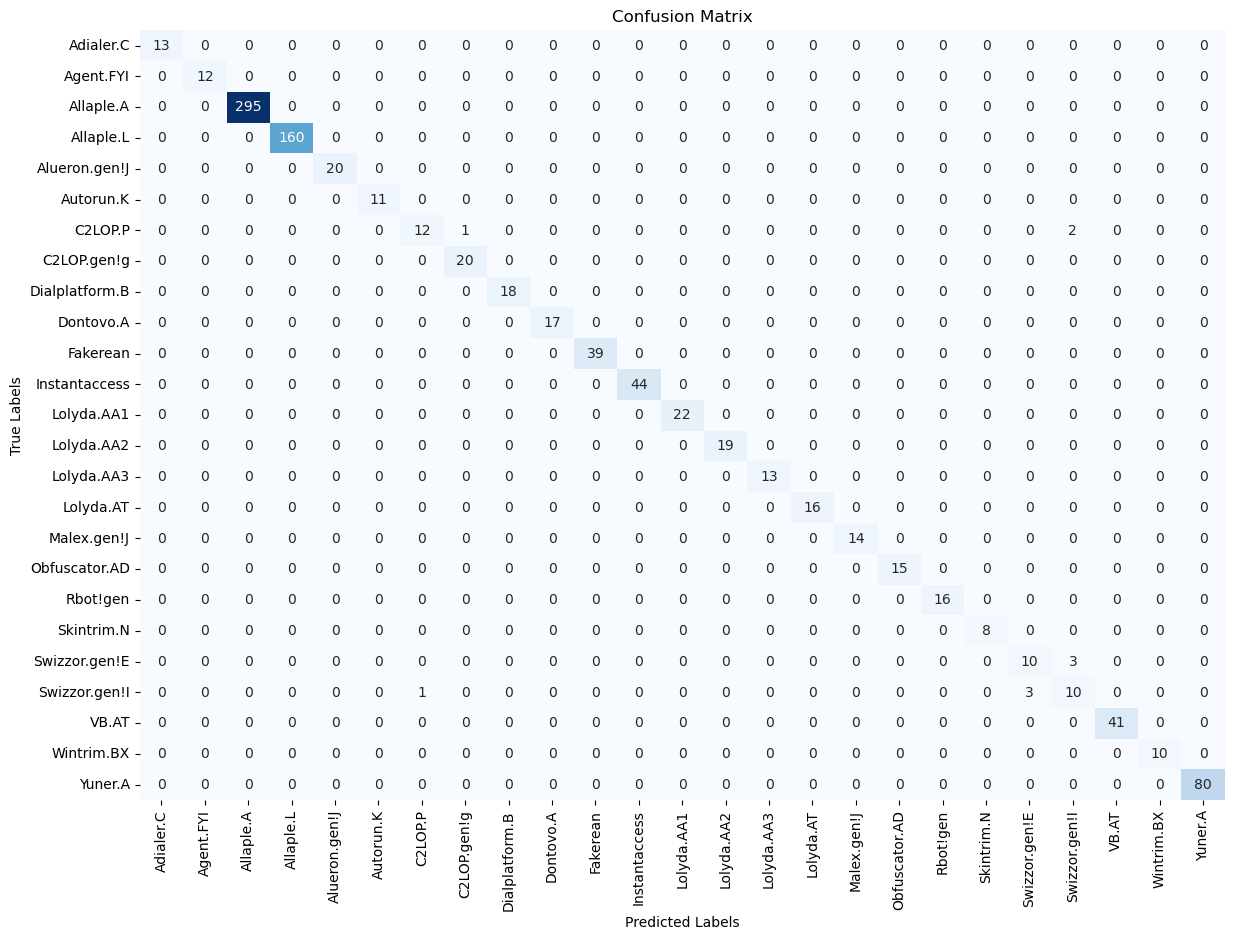

In [11]:
confusion_matrix = tf.math.confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(14, 10))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys()
           )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# VGG16

In [12]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False)
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
data_dir = 'malimg'

# Set a random seed for reproducibility
SEED = 74797569

# Define paths
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')

# Create an ImageDataGenerator for each set
datagen = ImageDataGenerator(rescale=1./255)

batch_size = 64
image_dim = 150

# Create train generator
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(image_dim, image_dim),
    batch_size=batch_size,
    #color_mode='grayscale',
    class_mode='categorical',  # or 'categorical' if you have multiple classes
    seed=SEED
)

# Create validation generator
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(image_dim, image_dim),
    batch_size=batch_size,
    #color_mode='grayscale',
    class_mode='categorical',  # or 'categorical' if you have multiple classes
    seed=SEED
)

# Create test generator
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(image_dim, image_dim),
    batch_size=batch_size,
    shuffle=False,
    #color_mode='grayscale',
    class_mode='categorical',  # or 'categorical' if you have multiple classes
    seed=SEED
)


Found 6527 images belonging to 25 classes.
Found 1867 images belonging to 25 classes.
Found 945 images belonging to 25 classes.


In [14]:
keras.backend.clear_session()

inputs = keras.Input(shape=(150, 150, 3))
x = conv_base(inputs, training=False)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)

outputs = layers.Dense(25, activation='softmax')(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[
                  'accuracy'
              ])

callbacks = [
    ModelCheckpoint('malimg_models/model_vgg16.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=20, verbose=1),
    # LearningRateScheduler(scheduler, verbose=1)
]

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         3,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,766,617 (60.14 MB)

 Trainable params: 15,766,617 (60.14 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history_vgg16 = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/50


/opt/conda/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.2885 - loss: 2.8594
Epoch 1: val_accuracy improved from -inf to 0.77183, saving model to malimg_models/model_vgg16.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 72s 475ms/step - accuracy: 0.2893 - loss: 2.8540 - val_accuracy: 0.7718 - val_loss: 1.0509
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.7623 - loss: 0.8790
Epoch 2: val_accuracy improved from 0.77183 to 0.86074, saving model to malimg_models/model_vgg16.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 28s 264ms/step - accuracy: 0.7625 - loss: 0.8783 - val_accuracy: 0.8607 - val_loss: 0.4113
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9146 - loss: 0.2888
Epoch 3: val_accuracy improved from 0.86074 to 0.94162, saving model to malimg_models/model_vgg16.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 28s 261ms/step - accuracy: 0.9147 - loss: 0.2884 - val_accuracy: 0.9416 - val_loss: 0.2141
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9485 - los

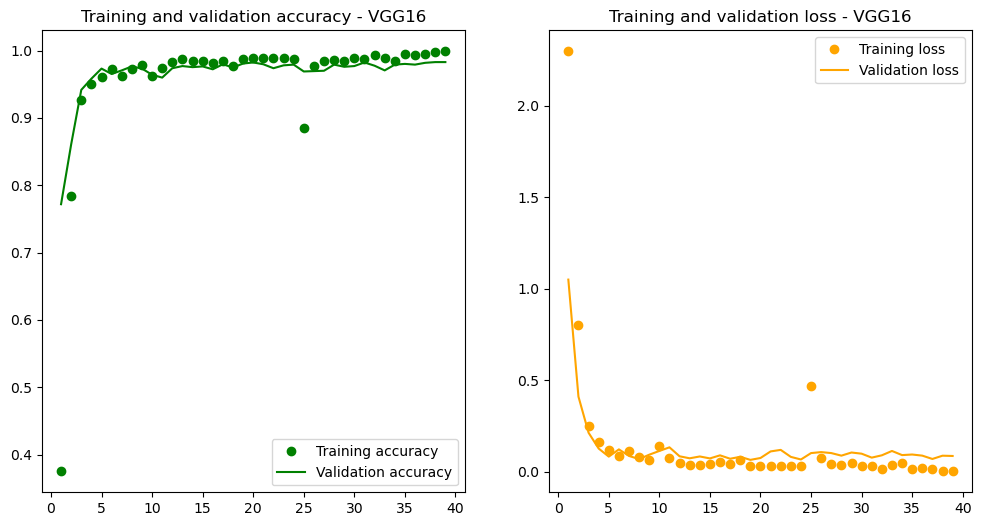

In [42]:
acc = history_vgg16.history['accuracy']
val_acc = history_vgg16.history['val_accuracy']
loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

plt.plot(epochs, acc, 'go', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy - VGG16')
plt.legend()

plt.subplot(1, 2, 2)

plt.plot(epochs, loss, 'o', label='Training loss', color='orange')
plt.plot(epochs, val_loss, label='Validation loss', color='orange')
plt.title('Training and validation loss - VGG16')
plt.legend()
plt.savefig('vgg16_accloss.jpg')
plt.show()

## Testing

In [17]:
test_model = keras.models.load_model('malimg_models/model_vgg16.keras')
# Evaluate the model on the test data using `evaluate`
test_loss, test_accuracy = test_model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

/opt/conda/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 614ms/step - accuracy: 0.9931 - loss: 0.0197
Test Loss: 0.046792205423116684
Test Accuracy: 0.9820106029510498


In [18]:
predictions = test_model.predict(test_generator)
pred_labels = predictions.argmax(axis=1)
true_labels = test_generator.classes

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 255ms/step


In [19]:
print('Accuracy: ', accuracy_score(true_labels, pred_labels))
print('Precision: ', precision_score(true_labels, pred_labels, average='macro'))
print('Recall: ', recall_score(true_labels, pred_labels, average='macro'))

Accuracy:  0.982010582010582
Precision:  0.9565465838509317
Recall:  0.9546049763244886


# VGG19

In [20]:
from tensorflow.keras.applications import VGG19

conv_base = VGG19(weights='imagenet',
                  include_top=False)
conv_base.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
data_dir = 'malimg'

# Set a random seed for reproducibility
SEED = 74797569

# Define paths
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')

# Create an ImageDataGenerator for each set
datagen = ImageDataGenerator(rescale=1./255)

batch_size = 64
image_dim = 150

# Create train generator
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(image_dim, image_dim),
    batch_size=batch_size,
    #color_mode='grayscale',
    class_mode='categorical',  # or 'categorical' if you have multiple classes
    seed=SEED
)

# Create validation generator
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(image_dim, image_dim),
    batch_size=batch_size,
    #color_mode='grayscale',
    class_mode='categorical',  # or 'categorical' if you have multiple classes
    seed=SEED
)

# Create test generator
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(image_dim, image_dim),
    batch_size=batch_size,
    shuffle=False,
    #color_mode='grayscale',
    class_mode='categorical',  # or 'categorical' if you have multiple classes
    seed=SEED
)


Found 6527 images belonging to 25 classes.
Found 1867 images belonging to 25 classes.
Found 945 images belonging to 25 classes.


In [23]:
keras.backend.clear_session()

inputs = keras.Input(shape=(150, 150, 3))
x = conv_base(inputs, training=False)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)

outputs = layers.Dense(25, activation='softmax')(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[
                  'accuracy'
              ])

callbacks = [
    ModelCheckpoint('malimg_models/model_vgg19.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=20, verbose=1),
    # LearningRateScheduler(scheduler, verbose=1)
]

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 4, 4, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         3,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,076,313 (80.40 MB)

 Trainable params: 21,076,313 (80.40 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history_vgg19 = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/50


/opt/conda/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.2667 - loss: 2.9538
Epoch 1: val_accuracy improved from -inf to 0.31602, saving model to malimg_models/model_vgg19.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 41s 325ms/step - accuracy: 0.2671 - loss: 2.9508 - val_accuracy: 0.3160 - val_loss: 2.5212
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.3167 - loss: 2.5071
Epoch 2: val_accuracy did not improve from 0.31602
102/102 ━━━━━━━━━━━━━━━━━━━━ 28s 257ms/step - accuracy: 0.3167 - loss: 2.5073 - val_accuracy: 0.3160 - val_loss: 2.5316
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.3136 - loss: 2.5320
Epoch 3: val_accuracy did not improve from 0.31602
102/102 ━━━━━━━━━━━━━━━━━━━━ 30s 275ms/step - accuracy: 0.3137 - loss: 2.5319 - val_accuracy: 0.3160 - val_loss: 2.5319
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.3057 - loss: 2.5597
Epoch 4: val_accuracy did not improve from 0.31602
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 250ms/step -

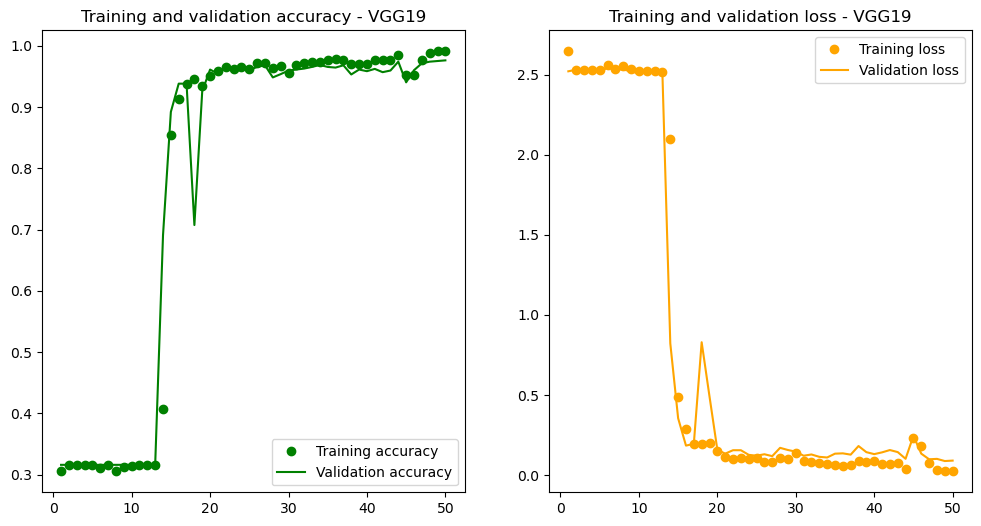

In [43]:
acc = history_vgg19.history['accuracy']
val_acc = history_vgg19.history['val_accuracy']
loss = history_vgg19.history['loss']
val_loss = history_vgg19.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

plt.plot(epochs, acc, 'go', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy - VGG19')
plt.legend()

plt.subplot(1, 2, 2)

plt.plot(epochs, loss, 'o', label='Training loss', color='orange')
plt.plot(epochs, val_loss, label='Validation loss', color='orange')
plt.title('Training and validation loss - VGG19')
plt.legend()
plt.savefig('vgg19_accloss.jpg')
plt.show()

## Testing

In [26]:
test_model = keras.models.load_model('malimg_models/model_vgg19.keras')
# Evaluate the model on the test data using `evaluate`
test_loss, test_accuracy = test_model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

/opt/conda/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.9887 - loss: 0.0244
Test Loss: 0.05588187649846077
Test Accuracy: 0.9777777791023254


In [27]:
predictions = test_model.predict(test_generator)
pred_labels = predictions.argmax(axis=1)
true_labels = test_generator.classes

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 258ms/step


In [28]:
print('Accuracy: ', accuracy_score(true_labels, pred_labels))
print('Precision: ', precision_score(true_labels, pred_labels, average='macro'))
print('Recall: ', recall_score(true_labels, pred_labels, average='macro'))

Accuracy:  0.9777777777777777
Precision:  0.9479405243878929
Recall:  0.9464118361313483
